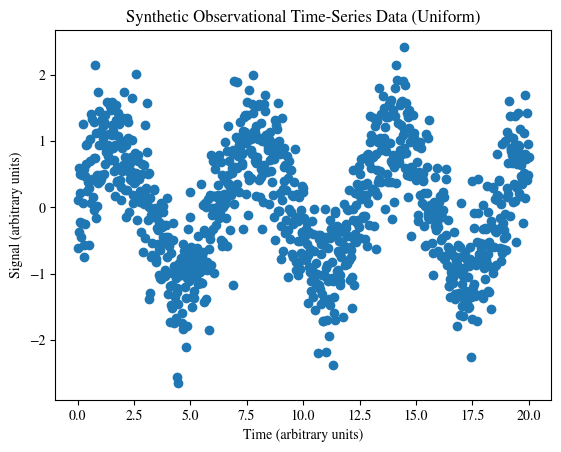

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams["figure.dpi"] = 1200
# construct synthetic observational time-series data at even spacing

N = 1000

t = np.linspace(0, 20, N) # 1000 evenly spaced points between 0 and 20
y = np.sin(t) # sinusodial signal

scale = 0.5 # scale of noise, multiplies Gaussian random noise

rng = np.random.default_rng()
r = rng.standard_normal(N)
r = scale * r

experimental_signal = y + r

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time (arbitrary units)")
ax.set_ylabel("Signal (arbitrary units)")
ax.set_title("Synthetic Observational Time-Series Data (Uniform)")
ax.scatter(t, experimental_signal)

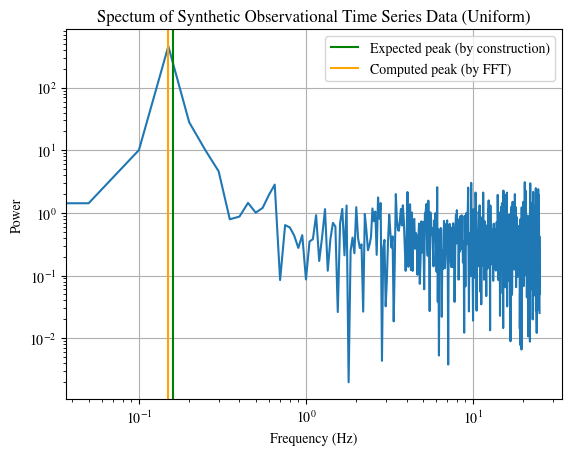

In [2]:
# let's show that the FFT can accurately recover the spectral content of this signal:
# since it's built from sin(x), we expect a frequency peak at 1 / 2pi ~ 0.16

F = np.fft.rfft(experimental_signal)
kfreq = np.fft.rfftfreq(len(t), d=t.max() / len(t))
power = np.abs(F) ** 2 * 2 / len(t)
kfreq_of_max_power = kfreq[np.argmax(power)]

fig, ax = plt.subplots()
ax.plot(kfreq, power)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Power")
ax.set_title("Spectum of Synthetic Observational Time Series Data (Uniform)")
ax.set_xlabel("Frequency (Hz)")
ax.axvline(x = 1/(2*np.pi), label = "Expected peak (by construction)", color = "green")
ax.axvline(x = kfreq_of_max_power, label = "Computed peak (by FFT)", color = "orange")
ax.legend()
ax.grid()

In [3]:
# now let's study the missing data problem: let's suppose that time measurements [18-56]; [256-300]; [700-806]; [910-981] drop out

def dropped_indices(input_min, input_max, number_of_dropped_intervals, max_length_of_dropped_interval):
    
    list_of_dropped_indices = []
    
    for i in range(number_of_dropped_intervals): 
        
        starting_point = rng.integers(input_min, input_max + 1) # pick a random point from which to start dropping
        length = rng.integers(1, max_length_of_dropped_interval + 1) # go out a variable length after the start to get the dropped companions 
        dropped_indices = [starting_point + j for j in range(length) if (starting_point + j) < input_max] # conditional in case we overshoot input_max
        
        list_of_dropped_indices.append(dropped_indices)
    
    # note that we don't do anything to prevent overlapping intervals, but it doesn't really matter 
    
    flattened_list_of_dropped_indices = [index for sublist in list_of_dropped_indices for index in sublist]
    
    return list_of_dropped_indices, list(set(flattened_list_of_dropped_indices)) # only the unique ones

In [4]:
no_dropped = 5
max_len_dropped = N / 5

list_of_dropped_intervals, instrumentally_dropped_indices = dropped_indices(0, N, no_dropped, max_len_dropped)

missing_problem_times = np.delete(t, instrumentally_dropped_indices)
missing_problem_data = np.delete(experimental_signal, instrumentally_dropped_indices) 
# the times and the signal have the same index structure

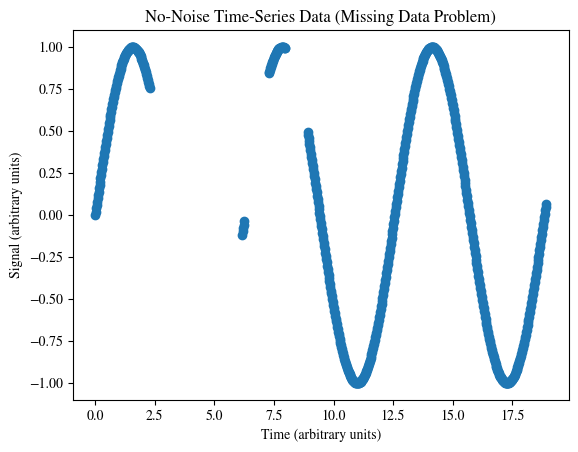

In [5]:
# now let's show that the function works as desired -- it's easier to see this with y than with experimental_signal

missing_y_data = np.delete(y, instrumentally_dropped_indices)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time (arbitrary units)")
ax.set_ylabel("Signal (arbitrary units)")
ax.set_title("No-Noise Time-Series Data (Missing Data Problem)")
ax.scatter(missing_problem_times, missing_y_data)

In [6]:
# now that we clearly see the function works, let's show the real, noisy data with the instrumental drop out applied

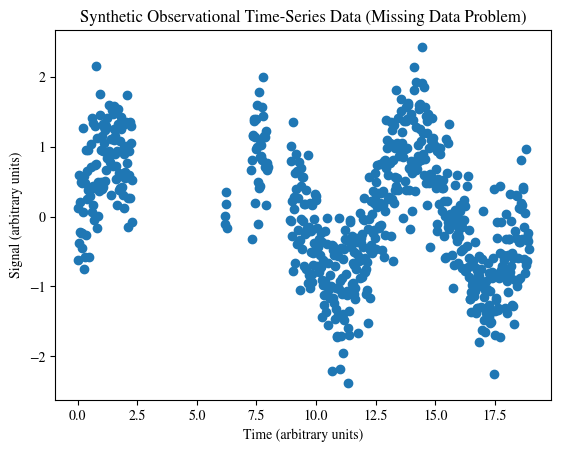

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time (arbitrary units)")
ax.set_ylabel("Signal (arbitrary units)")
ax.set_title("Synthetic Observational Time-Series Data (Missing Data Problem)")
ax.scatter(missing_problem_times, missing_problem_data)

In [8]:
# from Numerical Recipes:
# "If a lot of consecutive points are missing, you might as well just
# set them to zero, or perhaps “clamp” the value at the last measured point."
# we will use this as the basis for our interpolation scheme: we will say 
# a "lot" is an interval having length 5% or more of the total number of points
# and we'll clamp at the last measured value for such intervals
# and for smaller missing intervals, we'll do a linear interpolation between last measured point
# and next measured point
# why not just always do a linear interpolation? it could be totally spurious if lots of points are missing
# -- you might miss entire period(s) of action; and especially for the real, noisy data

def interpolated_experimental_data(N, dropped_intervals, experimental_data, size_threshold = 0.05):
    
    # note that here dropped_intervals is the unflattened list of lists
    
    signal_with_interpolation = np.copy(experimental_data)

    for interval in dropped_intervals:
    
        left = min(interval)
        right = max(interval)
        length = (right - left)
    
        if length / N >= size_threshold:
            a_lot = True
        else:
            a_lot = False
        
        if a_lot:
            signal_with_interpolation[left: right] = experimental_signal[left - 1] # clamp
        else:
            if right + 1 < N : # avoid out of bounds error
                signal_with_interpolation[left: right] = (experimental_signal[left - 1] + experimental_signal[right + 1]) / 2 # linear
            else:
                signal_with_interpolation[left: right] = (experimental_signal[left - 1] + experimental_signal[N-1]) / 2
        
    return signal_with_interpolation

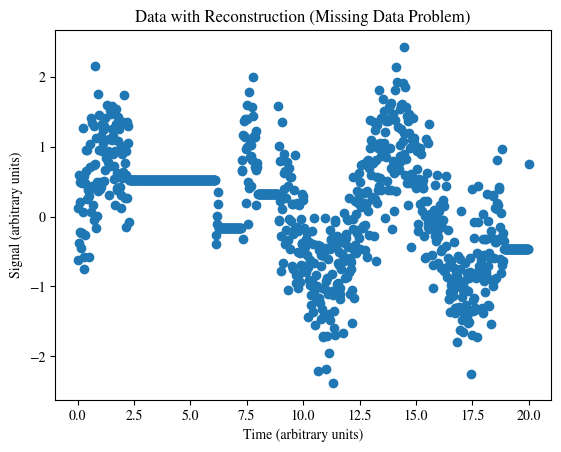

In [9]:
signal_with_interpolation = interpolated_experimental_data(N, list_of_dropped_intervals, experimental_signal)

# let's have a look to make sure this does what we want it to do

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("Time (arbitrary units)")
ax.set_ylabel("Signal (arbitrary units)")
ax.set_title("Data with Reconstruction (Missing Data Problem)")
ax.scatter(t, signal_with_interpolation)

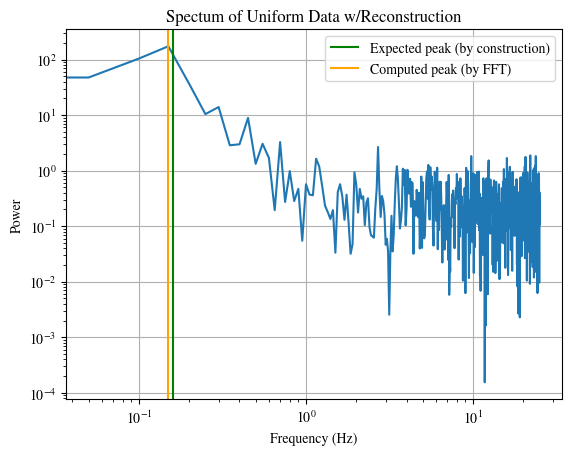

In [10]:
# let's show that the FFT has a hard time accurately recovering the spectral content of this signal:
# since it's built from sin(x), we expect a frequency peak at 1 / 2pi ~ 0.16
# if the gaps are fairly small, as may happen by chance, the FFT does okay
# but if they are somewhat comparable to a fraction of a wavelength, then we have catastrophic failure
# as shown in the Motivation section

F = np.fft.rfft(signal_with_interpolation)
kfreq = np.fft.rfftfreq(len(t), d=t.max() / len(t))
power = np.abs(F) ** 2 * 2 / len(t)
kfreq_of_max_power = kfreq[np.argmax(power)]

fig, ax = plt.subplots()
ax.plot(kfreq, power)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("Power")
ax.set_title("Spectum of Uniform Data w/Reconstruction")
ax.set_xlabel("Frequency (Hz)")
ax.axvline(x = 1/(2*np.pi), label = "Expected peak (by construction)", color = "green")
ax.axvline(x = kfreq_of_max_power, label = "Computed peak (by FFT)", color = "orange")
ax.legend()
ax.grid()